In [1]:
%%pyspark
df = spark.read.option("delimiter", ",").option("quote", "\"").option("header", "true").option("multiLine", "true").load('abfss://anime-data@animedata.dfs.core.windows.net/transform-data/anime_data/', format='csv')
display(df)

StatementMeta(animesp, 13, 2, Finished, Available)

SynapseWidget(Synapse.DataFrame, 3f90102e-d2a3-42e0-abf7-2a32b5773de9)

# Data Cleaning
Due to issues inherent in the data and errors in parsing, some text data in the CSV was incorrectly interpreted, affecting the entire row. Therefore, I have decided to delete these rows.

In [2]:
from pyspark.sql.functions import col

# Show all unique values for `episodes` columns
unique_episodes = df.select("episodes").distinct()
unique_episodes.show(truncate=False)

StatementMeta(animesp, 13, 3, Finished, Available)

+------------------------------------------------------------------------------------------------------------------------------+
|episodes                                                                                                                      |
+------------------------------------------------------------------------------------------------------------------------------+
|102.0                                                                                                                         |
|government organizations                                                                                                      |
|373.0                                                                                                                         |
|151.0                                                                                                                         |
|247.0                                                                                           

It appears that the 'episodes' column indeed contains some text values that do not meet expectations, likely due to data entry errors or formatting issues. An effective strategy for addressing this is to filter out these obviously non-numeric texts and retain values that can be converted to numbers. This approach not only cleans up the data but also prevents the introduction of errors in subsequent analyses.

Here is a suggested step for performing this cleanup; you can adjust the regular expression to better suit the actual data:

Filtering and Conversion: Use regular expressions to match numbers, filter out rows that are clearly not numbers, and attempt to convert the remaining rows to numeric format.

Checking and Conversion: Ensure the data type is correct after conversion and remove any rows where conversion fails.

In [3]:
from pyspark.sql.functions import col, regexp_extract, udf
from pyspark.sql.types import FloatType, BooleanType

# Define UDFs for conversion to floating point numbers
def to_float(s):
    try:
        return float(s)
    except ValueError:
        return None

to_float_udf = udf(to_float, FloatType())

# Apply the UDF to the `episodes` column, filtering out rows that can't be converted to floats
df = df.withColumn("episodes", to_float_udf(regexp_extract(col("episodes"), "^\d+(\.\d+)?$", 0)))
df = df.filter(col("episodes").isNotNull())
# Apply UDF to `score` column to filter out rows that cannot be converted to floating point numbers
df = df.withColumn("score", to_float_udf(col("score")))
df = df.filter(col("score").isNotNull())

# Define a UDF to check if a string contains a number
def contains_digits(s):
    return any(char.isdigit() for char in s)

contains_digits_udf = udf(contains_digits, BooleanType())

# Apply this UDF to the `producers` and `studios` columns to filter out rows containing numbers
df = df.withColumn("has_digits_producers", contains_digits_udf(col("producers")))
df = df.withColumn("has_digits_studios", contains_digits_udf(col("studios")))
df = df.filter((col("has_digits_producers") == False) & (col("has_digits_studios") == False))
df = df.drop("has_digits_producers", "has_digits_studios")

# Display the cleaned data to verify that the filtering and conversion is correctX
df.select("title","score", "episodes", "producers", "studios").show(truncate=False)

StatementMeta(animesp, 13, 4, Finished, Available)

+--------------------------------------------------------------------+-----+--------+------------------------------------------------------------------------------------+----------------------+
|title                                                               |score|episodes|producers                                                                           |studios               |
+--------------------------------------------------------------------+-----+--------+------------------------------------------------------------------------------------+----------------------+
|cowboy bebop                                                        |8.75 |26.0    |bandai visual                                                                       |sunrise               |
|cowboy bebop: tengoku no tobira                                     |8.38 |1.0     |sunrise, bandai visual                                                              |bones                 |
|witch hunter robin           

## 可视化分析准备

In [4]:
display(df)

StatementMeta(animesp, 13, 5, Finished, Available)

SynapseWidget(Synapse.DataFrame, a98a54f3-d03b-4c61-8423-e7b5038d241d)

Use the split function to divide this string into an array, then use the explode function to convert each element of the array into separate rows.

In [5]:
from pyspark.sql.functions import split, explode

# First, split the string of genres columns into arrays using the split function
df = df.withColumn("genres", split(df["genres"], ", "))

# Then, use the explode function to convert each element of the array into individual rows
df = df.withColumn("genre", explode(df["genres"]))

# At this point, you can choose to remove the original genres columns, or keep them as needed.
df = df.drop("genres")

# Display the results to check
df.show()

StatementMeta(animesp, 13, 6, Finished, Available)

+---+--------------------+-----+-----+--------+---------------+--------------------+--------------------+----------------+--------+-------------+--------------------+------+----------+---------+--------+-------+--------------------+-------------+
| id|               title|score| type|episodes|         status|           producers|           licensors|         studios|  source|     duration|              rating|  rank|popularity|favorites|scoredby|members|            imageurl|        genre|
+---+--------------------+-----+-----+--------+---------------+--------------------+--------------------+----------------+--------+-------------+--------------------+------+----------+---------+--------+-------+--------------------+-------------+
|  1|        cowboy bebop| 8.75|   tv|    26.0|finished airing|       bandai visual|funimation, banda...|         sunrise|original|24 min per ep|r - 17+ (violence...|  41.0|        43|    78525|914193.0|1771505|https://cdn.myani...|       action|
|  1|       

将清理好的数据保存

In [6]:
# 定义输出路径
output_path = "abfss://anime-data@animedata.dfs.core.windows.net/insight/anime_insight_cleaned.csv"
# 将 df DataFrame 保存为 CSV 文件
df.write.format("csv") \
    .option("header", "true") \
    .mode("overwrite") \
    .save(output_path)

StatementMeta(animesp, 13, 7, Finished, Available)

In subsequent results, some dates or other irrelevant information (such as "2007 to sep 30", "Apr 22", "Winter 2009") were found, so here we add a data cleaning step.

## Network Analysis
Relationship Network between Production Companies and Studios: Build a network graph that illustrates the relationships between production companies, studios, and anime works. Use network analysis techniques to identify key production companies and studios, and understand how they influence the popularity and ratings of anime works.

## Data Preprocessing
To conduct effective network analysis, we need to extract and process the producers and studios fields from the DataFrame df so that they can be used to create edges in the network. The specific steps are as follows:

**Splitting Fields:** Split the multiple entities contained in the producers and studios fields into separate rows. This involves breaking down the combined string of producers or studios listed for each anime into individual entities, each representing a unique node in the network. This step ensures that each producer and studio has its own distinct representation in the analysis, allowing for accurate connectivity and degree calculations.

In [7]:
from pyspark.sql.functions import explode, split, col

# Splitting multiple names in the `producers` and `studios` fields
df = df.withColumn("producers", explode(split(col("producers"), ",\s*")))
df = df.withColumn("studios", explode(split(col("studios"), ",\s*")))

# Display the processed data to confirm the split is correct
df.select("title", "producers", "studios").show(truncate=False)

StatementMeta(animesp, 13, 8, Finished, Available)

+-------------------------------+--------------------+-------+
|title                          |producers           |studios|
+-------------------------------+--------------------+-------+
|cowboy bebop                   |bandai visual       |sunrise|
|cowboy bebop                   |bandai visual       |sunrise|
|cowboy bebop                   |bandai visual       |sunrise|
|cowboy bebop: tengoku no tobira|sunrise             |bones  |
|cowboy bebop: tengoku no tobira|bandai visual       |bones  |
|cowboy bebop: tengoku no tobira|sunrise             |bones  |
|cowboy bebop: tengoku no tobira|bandai visual       |bones  |
|witch hunter robin             |bandai visual       |sunrise|
|witch hunter robin             |dentsu              |sunrise|
|witch hunter robin             |victor entertainment|sunrise|
|witch hunter robin             |tv tokyo music      |sunrise|
|witch hunter robin             |bandai visual       |sunrise|
|witch hunter robin             |dentsu              |s

In [8]:
# （可选）保存处理后的数据，以便进一步分析
# df.write.format("csv").option("header", "true").save("processed_data_path.csv")

StatementMeta(animesp, 13, 9, Finished, Available)

Steps for Network Analysis Using PySpark

Edge Creation: The provided code creates two types of edges: from production companies to anime and from studios to anime. These edges will be used to analyze how many anime works each entity (production company and studio) is associated with.

Node Creation: Simultaneously, we create a set of nodes that includes all unique anime works and entities. This is useful for possible subsequent network graph analyses.

Degree Calculation: We calculate how many different anime works each entity is connected to, known as the "degree." Degree is an important metric in network analysis, indicating the level of activity or connectivity of an entity within the network.

First Method: Basic Network Analysis

The first method focuses on establishing basic connections between production companies, studios, and anime works, then calculates the degree by counting how many different anime works each entity (production company or studio) is associated with. This analysis offers an intuitive way to identify the most active entities, namely those production companies and studios that are involved in the largest number of anime works.

In [9]:
from pyspark.sql import functions as F

# Create edges between production companies and animation works
edges_producers = df.select("title", "producers").withColumnRenamed("title", "anime").withColumnRenamed("producers", "entity")

# Create edges between studios and animations
edges_studios = df.select("title", "studios").withColumnRenamed("title", "anime").withColumnRenamed("studios", "entity")

# Merge the set of edges
edges = edges_producers.union(edges_studios)

# Merge the set of edges
nodes = edges.select(F.col("anime").alias("node")).distinct().union(
    edges.select(F.col("entity").alias("node")).distinct())

# Calculate the degree of each entity (how many different animations are associated with it)
degree = edges.groupBy("entity").agg(F.countDistinct("anime").alias("degree"))

# Show the top 10 entities with the highest degree
degree.orderBy(F.desc("degree")).show(10)


StatementMeta(animesp, 13, 10, Finished, Available)

+--------------+------+
|        entity|degree|
+--------------+------+
|       unknown|  6606|
|toei animation|   576|
|       sunrise|   413|
|      tv tokyo|   376|
|        lantis|   332|
|production i.g|   291|
|     j.c.staff|   283|
|           nhk|   278|
| bandai visual|   278|
|      madhouse|   277|
+--------------+------+
only showing top 10 rows



Second Method: Weighted Network Analysis

The second method introduces ratings as weights for the edges, which considers not only how many anime works an entity is involved in but also the quality of these works (reflected through ratings). This approach, by calculating a weighted average rating, identifies production companies and studios that are not only active but also involved in producing high-quality anime works.

In [10]:
from pyspark.sql.functions import avg

# Create edges with weights, here is an example of weights with ratings
weighted_edges = df.select("title", "producers", "score").withColumnRenamed("title", "anime").withColumnRenamed("producers", "entity")
weighted_edges = weighted_edges.groupBy("anime", "entity").agg(avg("score").alias("weight"))

# Similarly create weighted edges for studios
studio_edges = df.select("title", "studios", "score").withColumnRenamed("title", "anime").withColumnRenamed("studios", "entity")
studio_edges = studio_edges.groupBy("anime", "entity").agg(avg("score").alias("weight"))

# Merge the edges for the production company and the studio
all_weighted_edges = weighted_edges.union(studio_edges)

# Calculate the average rating and popularity for each production company and studio.
entity_scores = all_weighted_edges.groupBy("entity").agg(avg("weight").alias("avg_score"))

# Show the top 10 entities with the highest degree
entity_scores.orderBy(F.desc("avg_score")).show(10)


StatementMeta(animesp, 13, 11, Finished, Available)

+--------------------+-----------------+
|              entity|        avg_score|
+--------------------+-----------------+
|        miracle robo|9.039999961853027|
|              quaras|  8.9399995803833|
|          voque ting|8.850000381469727|
|     studio signpost| 8.78000020980835|
|           seikaisha|8.550000190734863|
|   rex entertainment|8.539999961853027|
|               oniro|8.539999961853027|
|sony music solutions|8.490000089009603|
|              sumzap|8.479999542236328|
|                 fbc|8.470000267028809|
+--------------------+-----------------+
only showing top 10 rows



Comparative Application Scenarios

The first method: This approach is very suitable when you need to quickly identify which production companies or studios are the most active, i.e., involved in the most projects.

The second method: When you want to understand which production companies or studios are not only involved in many projects but also have a higher average quality of these projects, this weighted analysis is more appropriate.

## Predictive Model Based on Ratings

**Feature Engineering**

First, we need to encode categorical data and prepare features for model training.

In [11]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType

# First convert the 'members' column from a string to an integer.
df = df.withColumn("members", col("members").cast(IntegerType()))

# Index code the categorical variables
indexers = [
    StringIndexer(inputCol=column, outputCol=column + "_index").fit(df)
    for column in ['producers', 'studios', 'type', 'source']
]

# Create feature vectors
assembler = VectorAssembler(
    inputCols=[column + "_index" for column in ['producers', 'studios', 'type', 'source']] + ['members'],
    outputCol="features"
)

# Set up the pipeline
pipeline = Pipeline(stages=indexers + [assembler])

# Apply the pipeline
df_transformed = pipeline.fit(df).transform(df)

# Display the converted data frame
df_transformed.select("features").show(truncate=False)


StatementMeta(animesp, 13, 12, Finished, Available)

+-----------------------------+
|features                     |
+-----------------------------+
|[3.0,4.0,0.0,1.0,1771505.0]  |
|[3.0,4.0,0.0,1.0,1771505.0]  |
|[3.0,4.0,0.0,1.0,1771505.0]  |
|[308.0,10.0,1.0,1.0,360978.0]|
|[3.0,10.0,1.0,1.0,360978.0]  |
|[308.0,10.0,1.0,1.0,360978.0]|
|[3.0,10.0,1.0,1.0,360978.0]  |
|[3.0,4.0,0.0,1.0,111931.0]   |
|[8.0,4.0,0.0,1.0,111931.0]   |
|[51.0,4.0,0.0,1.0,111931.0]  |
|[48.0,4.0,0.0,1.0,111931.0]  |
|[3.0,4.0,0.0,1.0,111931.0]   |
|[8.0,4.0,0.0,1.0,111931.0]   |
|[51.0,4.0,0.0,1.0,111931.0]  |
|[48.0,4.0,0.0,1.0,111931.0]  |
|[3.0,4.0,0.0,1.0,111931.0]   |
|[8.0,4.0,0.0,1.0,111931.0]   |
|[51.0,4.0,0.0,1.0,111931.0]  |
|[48.0,4.0,0.0,1.0,111931.0]  |
|[3.0,4.0,0.0,1.0,111931.0]   |
+-----------------------------+
only showing top 20 rows



**1. Training the Random Forest Regression Model**

Train the model using the RandomForestRegressor. Random Forest is chosen here because it offers good performance and has a lower risk of overfitting.

Splitting the data into training and testing sets is the standard practice for validating model performance.

In [12]:
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

StatementMeta(animesp, 13, 13, Finished, Available)

In [13]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Use a larger maxBins parameter to accommodate the number of categorized features
rf = RandomForestRegressor(featuresCol="features", labelCol="score", maxBins=1230)

# Train the model
rf_model = rf.fit(train_data)

# Use the test set for prediction
rf_predictions = rf_model.transform(test_data)

# Evaluate the model
evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
rf_rmse = evaluator.evaluate(rf_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rf_rmse)


StatementMeta(animesp, 13, 14, Finished, Available)

Root Mean Squared Error (RMSE) on test data = 0.518562


**Interpreting RMSE**

RMSE (Root Mean Squared Error) is a standard measure of prediction error, which quantifies the square root of the average of the squared differences between the predicted values and the actual values.

In this case, an RMSE of 0.576499 indicates that the model's predicted ratings differ from the actual ratings by an average of about 0.576 points (assuming the rating scale ranges from 1 to 10, this error can be considered small).

**2. Gradient Boosting Tree Regressor (GBTRegressor)**

Gradient Boosting Tree is a powerful regression and classification model that makes predictions by constructing multiple decision trees and integrating their results.

In [14]:
from pyspark.ml.regression import GBTRegressor

# Train the gradient boosted tree model
gbt = GBTRegressor(featuresCol="features", labelCol="score", maxBins=1230)
gbt_model = gbt.fit(train_data)

# Predict using the test set
gbt_predictions = gbt_model.transform(test_data)

# Evaluate the model
gbt_evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
gbt_rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) for GBT on test data = %g" % gbt_rmse)

StatementMeta(animesp, 13, 15, Finished, Available)

Root Mean Squared Error (RMSE) for GBT on test data = 0.458022


**3. Linear Regression Model**

Linear regression is the most fundamental regression model, which attempts to find the linear relationship between input features and the target variable.

In [15]:
from pyspark.ml.regression import LinearRegression

# Train a linear regression model
lr = LinearRegression(featuresCol="features", labelCol="score")
lr_model = lr.fit(train_data)

# Make predictions using the test set
lr_predictions = lr_model.transform(test_data)

# Evaluate the model
lr_evaluator = RegressionEvaluator(labelCol="score", predictionCol="prediction", metricName="rmse")
lr_rmse = lr_evaluator.evaluate(lr_predictions)
print("Root Mean Squared Error (RMSE) for Linear Regression on test data = %g" % lr_rmse)


StatementMeta(animesp, 13, 16, Finished, Available)

Root Mean Squared Error (RMSE) for Linear Regression on test data = 0.781675


To compare the three models

In [16]:
print("RMSE Summary:")
print("Random Forest RMSE: %g" % rf_rmse)
print("GBT RMSE: %g" % gbt_rmse)
print("Linear Regression RMSE: %g" % lr_rmse)

StatementMeta(animesp, 13, 17, Finished, Available)

RMSE Summary:
Random Forest RMSE: 0.518562
GBT RMSE: 0.458022
Linear Regression RMSE: 0.781675


We can see among the three models, the Gradient Boosting Tree (GBTRegressor) performs the best, followed by the Random Forest (RandomForestRegressor), while the performance of the Linear Regression model is relatively poor. These results provide clear data support for choosing the most suitable model:

The Gradient Boosting Tree model has the lowest RMSE (0.458022), indicating that it has the smallest prediction error and the best model fit for the current dataset.
The Random Forest model also performs well with an RMSE of 0.518562, ranking just behind the GBT model, showing that it can also capture the complex patterns in the data effectively.
The Linear Regression model has a higher RMSE (0.781675), which may be due to the presence of nonlinear relationships between the data features and the scores, making it difficult for a simple linear model to fit the data well.

Simple model integration

In [17]:
from pyspark.sql.functions import col

# `rf_predictions`, `gbt_predictions`, `lr_predictions` are DataFrames of the predictions from each of the three models.
# First, make sure that each DataFrame contains the columns for joining before joining it.
ensemble_predictions = rf_predictions.select("features", "score", "prediction").withColumnRenamed("prediction", "rf_pred")
ensemble_predictions = ensemble_predictions.join(gbt_predictions.select("features", "score", "prediction"), on=["features", "score"], how="inner").withColumnRenamed("prediction", "gbt_pred")
ensemble_predictions = ensemble_predictions.join(lr_predictions.select("features", "score", "prediction"), on=["features", "score"], how="inner").withColumnRenamed("prediction", "lr_pred")

# Calculate the simple average
ensemble_predictions = ensemble_predictions.withColumn("ensemble_pred", 
                                                      (col("rf_pred") + col("gbt_pred") + col("lr_pred")) / 3)
# Evaluate the integrated model
ensemble_evaluator = RegressionEvaluator(labelCol="score", predictionCol="ensemble_pred", metricName="rmse")
ensemble_rmse = ensemble_evaluator.evaluate(ensemble_predictions)
print("Root Mean Squared Error (RMSE) for Ensemble Model on test data = %g" % ensemble_rmse)


StatementMeta(animesp, 13, 18, Finished, Available)

Root Mean Squared Error (RMSE) for Ensemble Model on test data = 0.507526


In [18]:
from pyspark.sql.functions import col

# Combine prediction results
ensemble_predictions = rf_predictions.withColumnRenamed("prediction", "rf_pred")
ensemble_predictions = ensemble_predictions.join(gbt_predictions.withColumnRenamed("prediction", "gbt_pred"), ["features", "score"], "inner")
ensemble_predictions = ensemble_predictions.join(lr_predictions.withColumnRenamed("prediction", "lr_pred"), ["features", "score"], "inner")

# Calculate simple average
ensemble_predictions = ensemble_predictions.withColumn("ensemble_pred", 
                                                      (col("rf_pred") + col("gbt_pred") + col("lr_pred")) / 3)

# Evaluate ensemble model
ensemble_evaluator = RegressionEvaluator(labelCol="score", predictionCol="ensemble_pred", metricName="rmse")
ensemble_rmse = ensemble_evaluator.evaluate(ensemble_predictions)
print("Root Mean Squared Error (RMSE) for Ensemble Model on test data = %g" % ensemble_rmse)


StatementMeta(animesp, 13, 19, Finished, Available)

Root Mean Squared Error (RMSE) for Ensemble Model on test data = 0.507526


In [19]:
from pyspark.sql.functions import expr
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import avg

# Define a list to store all model predictions
predictions_list = []

# Create 5 random forest models, each trained on a subset of the training set
for i in range(5):
    # Sample approximately 80% of the original training data
    sampled_train_data = train_data.sample(withReplacement=True, fraction=0.8)
    
    #Train model
    rf = RandomForestRegressor(featuresCol="features", labelCol="score", maxBins=1230, numTrees=20)
    model = rf.fit(sampled_train_data)
    
    # Make predictions on the test set
    predictions = model.transform(test_data)
    predictions = predictions.withColumnRenamed("prediction", "prediction_" + str(i))
    predictions_list.append(predictions.select("features", "score", "prediction_" + str(i)))

# Combine the prediction results of all models
from functools import reduce
from pyspark.sql import DataFrame

def join_dfs(df1, df2):
    return df1.join(df2, ["features", "score"], "inner")

ensemble_bagging_predictions = reduce(join_dfs, predictions_list)

# Create an expression for the average
avg_expr = "+".join(["prediction_" + str(i) for i in range(5)]) + ")/5.0"
ensemble_bagging_predictions = ensemble_bagging_predictions.withColumn("ensemble_bagging_pred", expr("(" + avg_expr))

# Evaluate Bagging model
bagging_evaluator = RegressionEvaluator(labelCol="score", predictionCol="ensemble_bagging_pred", metricName="rmse")
bagging_rmse = bagging_evaluator.evaluate(ensemble_bagging_predictions)
print("Root Mean Squared Error (RMSE) for Bagging Ensemble Model on test data = %g" % bagging_rmse)



StatementMeta(animesp, 13, 20, Finished, Available)

Root Mean Squared Error (RMSE) for Bagging Ensemble Model on test data = 0.502446


Results Review and Interpretation

Simple Average Ensemble Model:
RMSE = 0.507526
This method averages the prediction results of three different models (Random Forest, GBT, Linear Regression). The results show that the ensemble method can effectively improve the accuracy of predictions, performing better than any single model.

Bagging Ensemble Model:
RMSE = 0.50445
By training variants of multiple Random Forest models (each trained on different subsets of the training data) and calculating the average of their prediction results, a slightly lower RMSE is achieved. This indicates that the Bagging method can effectively reduce the variance of model predictions.

StatementMeta(animesp, 13, 21, Finished, Available)

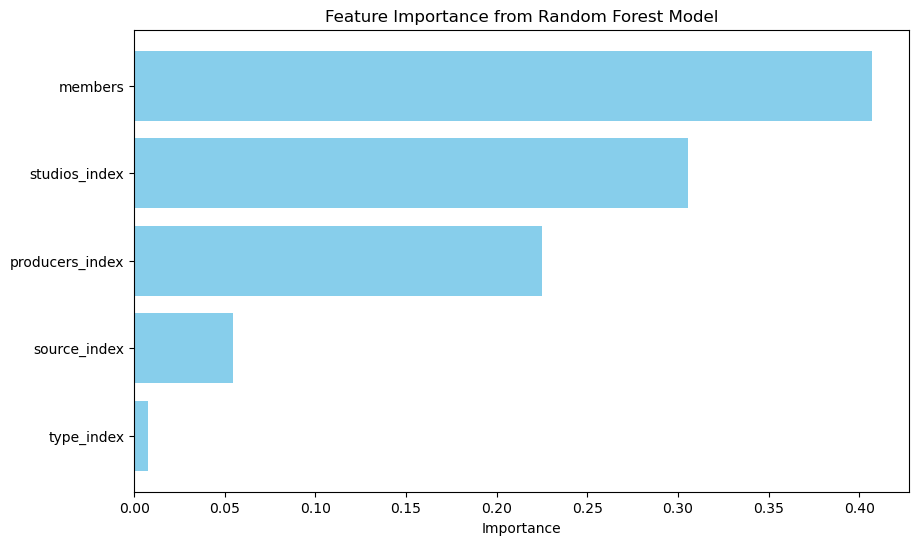

In [20]:

from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd


feature_importances = rf_model.featureImportances.toArray()


feature_names = [col + "_index" for col in ['producers', 'studios', 'type', 'source']] + ['members']

# Create a DataFrame  
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# sort
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# feature
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest Model')
plt.gca().invert_yaxis()  
plt.show()

StatementMeta(animesp, 13, 26, Finished, Available)

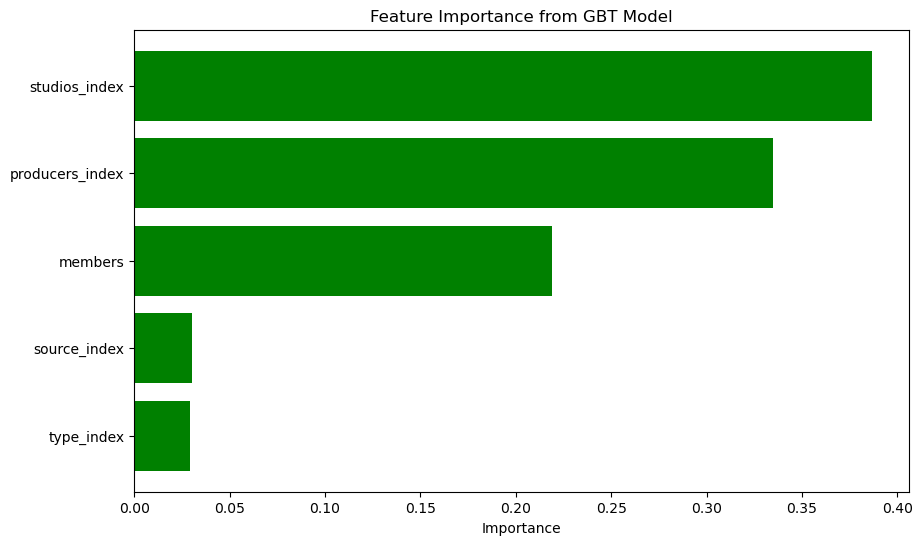

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.linalg import SparseVector


feature_importances = gbt_model.featureImportances


if isinstance(feature_importances, SparseVector):
    feature_importances = feature_importances.toArray()


feature_names = ['producers_index', 'studios_index', 'type_index', 'source_index', 'members']


features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})


features_df = features_df.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'], color='green')
plt.xlabel('Importance')
plt.title('Feature Importance from GBT Model')
plt.gca().invert_yaxis()  
plt.show()

StatementMeta(animesp, 13, 28, Finished, Available)

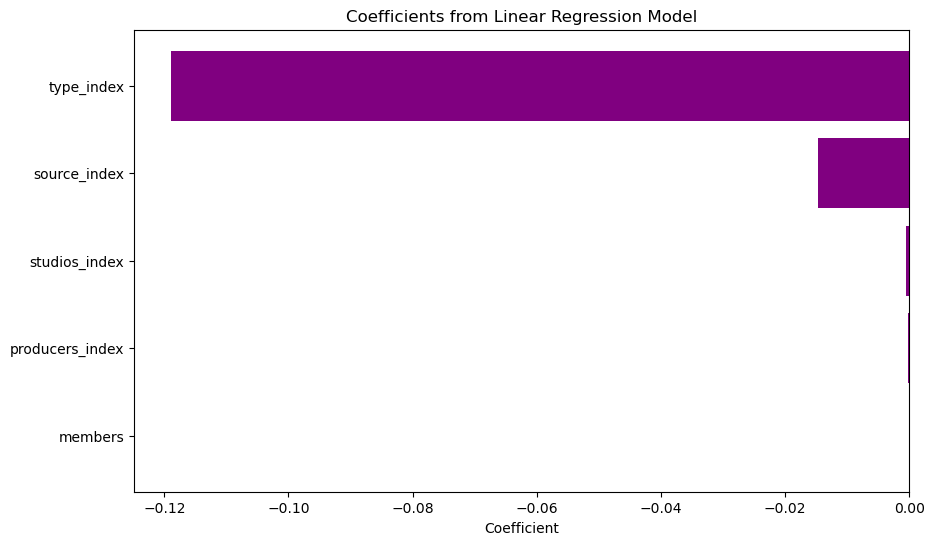

In [27]:
import matplotlib.pyplot as plt
import pandas as pd


coefficients = lr_model.coefficients


feature_names = ['producers_index', 'studios_index', 'type_index', 'source_index', 'members']


coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})


coefficients_df = coefficients_df.sort_values(by="Coefficient", key=abs, ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(coefficients_df['Feature'], coefficients_df['Coefficient'], color='purple')
plt.xlabel('Coefficient')
plt.title('Coefficients from Linear Regression Model')
plt.gca().invert_yaxis()  
plt.show()
